In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import torch.onnx

## Data Exploration

In [2]:
dataframes = []
train_data_directory = "../EyeTrackingTest/Data/Train"
for file in os.listdir(train_data_directory):
    dataframes.append(pd.read_csv(os.path.join(train_data_directory, file), delimiter=",").iloc[:,:-1])

In [3]:
for j in range(len(dataframes)):
    df = dataframes[j]
    labelx = []
    labely = []
    labelz = []
    for i in range(df.shape[0] - 1):
        label_row = df.iloc[i + 1]
        labelx.append(label_row["forward.x"])
        labely.append(label_row["forward.y"])
        labelz.append(label_row["forward.z"])

    df = df.iloc[:-1, :]
    df["label.x"] = labelx
    df["label.y"] = labely
    df["label.z"] = labelz
    dataframes[j] = df

dataframes[0].head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,638000597804996743,40413,560,-0.023819,0.115951,0.992966,0.016953,0.111084,0.993652,0.013144,0.088526,0.995987,0.013144,0.088526,0.995987
1,638000597805076741,40421,560,-0.023819,0.116440,0.992905,0.017181,0.109711,0.993805,0.013144,0.088526,0.995987,0.013634,0.088512,0.995982
2,638000597805166743,40430,561,-0.023788,0.116440,0.992905,0.015930,0.109009,0.993912,0.013634,0.088512,0.995982,0.013643,0.088508,0.995982
3,638000597805246741,40438,562,-0.023560,0.115784,0.992981,0.016022,0.109375,0.993866,0.013643,0.088508,0.995982,0.013599,0.088151,0.996014
4,638000597805326743,40446,563,-0.023300,0.115921,0.992981,0.014969,0.108475,0.993973,0.013599,0.088151,0.996014,0.013599,0.088151,0.996014


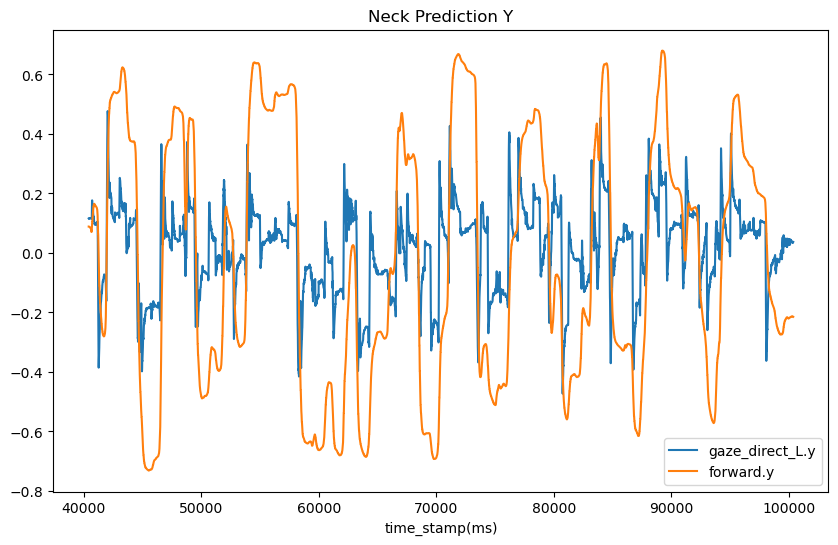

In [4]:
df = dataframes[0]
plt.figure(figsize=(10,6))
x = df["time_stamp(ms)"]
plt.xlabel("time_stamp(ms)")

plt.plot(x, df["gaze_direct_L.y"], label = "gaze_direct_L.y")
plt.plot(x, df["forward.y"], label="forward.y")


plt.title("Neck Prediction Y")
plt.legend()
plt.show()

In [5]:
min_size = float('inf')
for df in dataframes:
    if df.shape[0] < min_size:
        min_size = df.shape[0]

for df in dataframes:
    df = df[:min_size]

In [6]:
X_series = []
y_series = []
for df in dataframes:
    X = df.iloc[:, 3:-3].to_numpy()
    y = df.iloc[:, -3:].to_numpy()
    
    X = Variable(torch.Tensor(X))
    y = Variable(torch.Tensor(y))
    
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))
    X_series.append(X)
    y_series.append(y)
X_series = torch.cat(X_series, dim=1)
y_series = torch.stack(y_series, dim=1)
print(X_series.shape, y_series.shape)

torch.Size([7200, 6, 9]) torch.Size([7200, 6, 3])


## LSTM Model

In [7]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, output_size=3, hidden_size=9):
        super(CustomLSTM, self).__init__()
        self.num_classes = output_size
        self.num_layers = 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Tanh(),
            nn.Linear(self.hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, self.num_classes)
        )
    
    def forward(self, x, h_0=None, c_0=None):
        if h_0 is None:
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(torch.device("cuda"))
        if c_0 is None:
            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(torch.device("cuda"))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        _hn = hn.view(-1, self.hidden_size)
        out = self.fc(_hn)
        return out, hn, cn

## Training Loop and Results

In [8]:
def train(model, X, y, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    preds = torch.zeros((7200, 6, 3)).to(device)
    for j in range(X.shape[1]):
        instance = X[0:1, j:j+1, :]
        hn = None
        cn = None
        for i in range(6000):
            pred, hn, cn = model(instance, hn, cn)
            pred = nn.functional.normalize(pred)
            preds[i, j] = pred
            #cur_loss = criterion(pred, y[i:i+1, j])
            #loss += criterion(pred, y[i:i+1, j]) / (6000 * X.shape[1])
            #losses.append(cur_loss.item())
            
            if i < 5999:
                l_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,0:3] - pred[0], (1,3)))
                r_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,3:6] - pred[0], (1,3)))
                instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
    loss = criterion(preds[:6000], y[:6000])
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
def val(model, X, y, criterion, device):
    model.eval()
    preds = torch.zeros((7200, 6, 3)).to(device)
    for j in range(X.shape[1]):
        instance = X[0:1, j:j+1, :]
        hn = None
        cn = None
        for i in range(X.shape[0]):
            pred, hn, cn = model(instance, hn, cn)
            pred = nn.functional.normalize(pred)
            preds[i, j] = pred
            if i < X.shape[0] - 1:
                l_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,0:3] - pred[0], (1,3)))
                r_pred = nn.functional.normalize(torch.reshape(X[i+1,j:j+1,6:9] + X[i+1,j:j+1,3:6] - pred[0], (1,3)))
                instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
    loss = criterion(preds[6000:], y[6000:])
    return loss.item()

In [10]:
def train_loop(model, X, y, optimizer, device, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')
    counter = 0
    X = X.to(device)
    y = y.to(device)
    for epoch in range(num_epochs):
        train_loss = train(model, X, y, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        val_loss = val(model, X, y, criterion, device)
        val_losses.append(val_loss)
        
        print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, train_loss, 
                                                                 val_losses[epoch]))
        if val_losses[epoch] < min_val_loss:
            min_val_loss = val_losses[epoch]
            counter = 0
            torch.save(model.state_dict(), "best_val.pth")
        else:
            counter += 1
            if counter > 10:
                break
        
        if epoch % 10 == 0:
            scheduler.step()
        
    return train_losses, val_losses

In [11]:
learning_rate = 0.001
criterion = torch.nn.MSELoss()

device = torch.device("cuda")

lr_xyz = CustomLSTM(input_size=9).to(device)
optimizer = torch.optim.Adam(lr_xyz.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [12]:
train_losses, val_losses = train_loop(lr_xyz, X_series, y_series, optimizer, device, scheduler, 1000)

Epoch: 0, train loss: 0.55595, val loss: 0.26436
Epoch: 1, train loss: 0.29061, val loss: 0.14624
Epoch: 2, train loss: 0.16158, val loss: 0.10403
Epoch: 3, train loss: 0.10871, val loss: 0.09608
Epoch: 4, train loss: 0.09718, val loss: 0.09607
Epoch: 5, train loss: 0.09900, val loss: 0.09581
Epoch: 6, train loss: 0.10196, val loss: 0.09189
Epoch: 7, train loss: 0.10100, val loss: 0.08472
Epoch: 8, train loss: 0.09606, val loss: 0.07601
Epoch: 9, train loss: 0.08878, val loss: 0.06730
Epoch: 10, train loss: 0.08085, val loss: 0.05966
Epoch: 11, train loss: 0.07353, val loss: 0.05397
Epoch: 12, train loss: 0.06785, val loss: 0.04939
Epoch: 13, train loss: 0.06310, val loss: 0.04580
Epoch: 14, train loss: 0.05924, val loss: 0.04302
Epoch: 15, train loss: 0.05609, val loss: 0.04076
Epoch: 16, train loss: 0.05343, val loss: 0.03885
Epoch: 17, train loss: 0.05107, val loss: 0.03712
Epoch: 18, train loss: 0.04884, val loss: 0.03544
Epoch: 19, train loss: 0.04663, val loss: 0.03371
Epoch: 20,

In [13]:
lr_xyz.load_state_dict(torch.load("best_val.pth"))
torch.onnx.export(lr_xyz.cpu(),               # model being run
                  (X[0:1, 0:1, :], torch.zeros(1, 1, 9), torch.zeros(1, 1, 9)), # model input (or a tuple for multiple inputs)
                  "lr_xyz.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input', 'h0', 'c0'],   # the model's input names
                  output_names = ['output', 'hn', 'cn']) # the model's output names

TypeError: Expected state_dict to be dict-like, got <class 'method'>.

In [ ]:
X = X_series[:, 1:2, :]
y = y_series[:, 1, :]

print(X.shape, y.shape)
lr_xyz.to(device)

In [ ]:
train_predict, _, _ = lr_xyz(X.to(device))
data_predict = np.array([X[0, 0, 6:9].data.numpy()])
data_predict = np.append(data_predict, train_predict.data.cpu().numpy(), axis=0)

dataY_plot = np.array([X[0, 0, 6:9].data.numpy()])
dataY_plot = np.append(dataY_plot, y.data.numpy(), axis=0)
print(data_predict.shape, dataY_plot.shape)

In [ ]:
data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lr_xyz(instance.to(device), hn, cn)
    pred = nn.functional.normalize(pred)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 0], label="Actual Data")
#plt.plot(data_predict[:, 0], label="Predicted Data")
plt.plot(data_compound[:, 0], label="Compounded Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 1], label="Actual Data")
#plt.plot(data_predict[:, 1], label="Predicted Data")
plt.plot(data_compound[:, 1], label="Compounded Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 2], label="Actual Data")
#plt.plot(data_predict[:, 2], label="Predicted Data")
plt.plot(data_compound[:, 2], label="Compounded Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()

## Testing on New Series

In [ ]:
df = pd.read_csv("../EyeTrackingTest/Data/Test/1_0.txt", delimiter=",").iloc[:, :-1]

In [ ]:
labelx = []
labely = []
labelz = []
for i in range(df.shape[0] - 1):
    label_row = df.iloc[i + 1]
    labelx.append(label_row["forward.x"])
    labely.append(label_row["forward.y"])
    labelz.append(label_row["forward.z"])
    
df = df.iloc[:-1, :]
df["label.x"] = labelx
df["label.y"] = labely
df["label.z"] = labelz
df.head(5)

In [ ]:
X = df.iloc[:, 3:-3].to_numpy()
y = df.iloc[:, -3:].to_numpy()

print(X.shape, y.shape)

In [ ]:
X = Variable(torch.Tensor(X))
y = Variable(torch.Tensor(y))

X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

In [ ]:
train_predict, _, _ = lr_xyz(X.to(device))
data_predict = train_predict.data.cpu().numpy()
dataY_plot = y.data.numpy()

data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lr_xyz(instance.to(device), hn, cn)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

plt.figure(figsize=(10,6))

plt.plot(data)
plt.plot(dataY_plot[:, 0], label="Actual Data")
plt.plot(data_compound[:, 0], label="Predicted Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 1], label="Actual Data")
plt.plot(data_compound[:, 1], label="Predicted Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 2], label="Actual Data")
plt.plot(data_compound[:, 2], label="Predicted Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()